In [1]:
#loading the model

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K

# Define the custom LSTM layer
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Define a custom MSE function
def custom_mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

# Register custom objects
get_custom_objects().update({
    'CustomLSTM': CustomLSTM,
    'custom_mse': custom_mse
})

# Attempt to load the model
trained_model = load_model(r"C:\Users\pranali\Downloads\original_low_model.h5", 
                   custom_objects={'LSTM': CustomLSTM, 'mse': custom_mse})

# Print model summary
trained_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (CustomLSTM)               │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (CustomLSTM)             │ (None, 10, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,911 (859.03 KB)

 Trainable params: 219,909 (859.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [3]:
import numpy as np

X_test = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\Mature(1)\Mature-main\Datasets\Testing\all_data_low_test_x.npy")
y_test = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\Mature(1)\Mature-main\Datasets\Testing\all_data_low_test_y.npy")

In [5]:
import tensorflow as tf 
# Convert the model to a TensorFlow Lite model with Float16 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable Float16 quantization
converter.target_spec.supported_types = [tf.float16]

# Enable Select TF ops to support operations not natively supported by TFLite
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]

# Disable lowering of tensor list operations
converter._experimental_lower_tensor_list_ops = False

# Enable resource variable supporta
converter.experimental_enable_resource_variables = True

# Convert the model
tflite_float16_model = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\pranali\AppData\Local\Temp\tmpck1_i9qo\assets


INFO:tensorflow:Assets written to: C:\Users\pranali\AppData\Local\Temp\tmpck1_i9qo\assets


Saved artifact at 'C:\Users\pranali\AppData\Local\Temp\tmpck1_i9qo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 11), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2276321194640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276322428880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276321197328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276321197520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276322430224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276322429840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276322431376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276322432720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276322431184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2276322433872: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [7]:
# Save the TFLite model
with open('5G_low_quantized_f16.tflite', 'wb') as f:
    f.write(tflite_float16_model)

In [9]:
import tensorflow as tf
import numpy as np

# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_path='5G_low_quantized_f16.tflite')
interpreter.allocate_tensors()

# Get details of input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [11]:
import numpy as np
import time

# Initialize list to store predictions
predictions = []

# Measure inference time
start_time = time.time()
for i in range(X_test.shape[0]):
    # Prepare the input data (trim the extra dimension if necessary)
    input_data = X_test[i]  # Trim to match the expected shape (1, 10, 10)
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Append prediction to the list
    predictions.append(output_data)

end_time = time.time()
total_inference_time = end_time - start_time
avg_inference_time = total_inference_time / len(X_test)

print(f"Total Inference Time for quantized : {total_inference_time:.6f} seconds")
print(f"Avg Inference Time for quantized : {avg_inference_time:.6f} seconds")


Total Inference Time for quantized : 0.666037 seconds
Avg Inference Time for quantized : 0.001786 seconds


In [21]:
import os


# Get the size of the saved quantized TFLite model
model_size = os.path.getsize('5G_low_quantized_f16.tflite')
print(f"Float16 TFLite model size: {model_size / 1024:.2f} KB")  # Convert to KB



Float16 TFLite model size: 448.58 KB


Mean Signed Error: 64.6852
Median Signed Error: 114.0077
Standard Deviation of Errors: 392.5363


Text(0, 0.5, 'Signed Error')

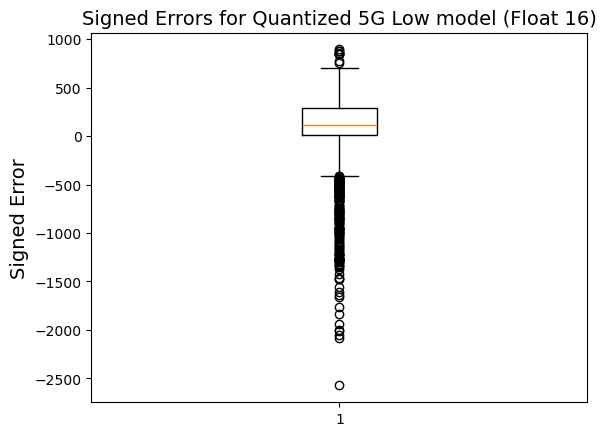

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Run inference on the quantized model
predictions = []
for i in range(X_test.shape[0]):
    input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)  # Adjust dtype if needed
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

predictions = np.squeeze(np.array(predictions))  # Adjust shape if necessary

# Reshape y_test to match the shape of predictions
y_test_squeezed = np.squeeze(y_test)  # From (3995, 5, 1) to (3995, 5)

# Calculate signed errors
signed_errors = predictions - y_test_squeezed

# Flatten signed_errors to combine all errors into a single array
signed_errors_flattened = signed_errors.flatten()

# Error statistics
mean_error = np.mean(signed_errors)
median_error = np.median(signed_errors)
std_error = np.std(signed_errors)

print(f"Mean Signed Error: {mean_error:.4f}")
print(f"Median Signed Error: {median_error:.4f}")
print(f"Standard Deviation of Errors: {std_error:.4f}")

import matplotlib.pyplot as plt
plt.boxplot(signed_errors_flattened)
plt.title('Signed Errors for Quantized 5G Low model (Float 16)',fontsize=14)
plt.ylabel('Signed Error',fontsize=14)


In [25]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Calculate MAE
mae = mean_absolute_error(y_test_squeezed, predictions)
# Calculate Mean Squared Error (MSE) as the test loss
mse = mean_squared_error(y_test_squeezed, predictions)
test_loss = mse  # Assuming MSE is the loss functiona

#print(f"Mean Squared Error (MSE) of the Quantized Model: {mse:.6f}")
print(f"Test Loss (MSE) of the Quantized Model: {test_loss:.6f}")
print(f"Mean Absolute Error (MAE) of the Quantized Model: {mae:.6f}")

Test Loss (MSE) of the Quantized Model: 158268.914433
Mean Absolute Error (MAE) of the Quantized Model: 277.100795
